In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import scipy
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

The mechanics of LLMs would seem to suggest otherwise: a predictive model trained on human data would replicate the random number generation behavior of humans, and humans are <a href="http://www.loper-os.org/bad-at-entropy/manmach.html" target="_blank">notoriously bad randomizers</a>. In this blog post, I'll embark on a whirlwind tour of stochasticity within computers and explore some statistical methods for testing randomness, applying them to output from ChatGPT.

### Post Contents
Below are the contents for this post — feel free to skip to [the third section](#Evaluating-ChatGPT's-random-numbers) if you're only interested in the results relevant to ChatGPT.

1. [Prelude: pseudorandom numbers](#Prelude:-pseudorandom-numbers)
    - [Methods for pseudorandom number generation](#Methods-for-pseudorandom-number-generation)
2. [Testing uniformity](#Testing-uniformity)
    - [Notable statistical tests](#Notable-statistical-tests)
    - [Other methods](#Other-methods)
        - [Birthday spacings](#Birthday-spacings)
        - [Runs tests](#Runs-tests)
3. [Evaluating ChatGPT's random numbers](#Evaluating-ChatGPT's-random-numbers)
    - [Method](#Method)
    - [Results](#Results)
    - [Discussion](#Discussion)
    - [Conclusion](#Conclusion)
4. [Appendix](#Appendix)

## Prelude: pseudorandom numbers

When you roll a six-sided die on a flat surface, you are initiating a stochastic process to generate a "true" random number: the forces on the die owing to gravity, your toss, and air resistance work in combination with the geometries of the die and the surface to produce a face-up number between one and six. Theoretically, this is a random number generator (RNG) over the range $[1..6]$: if you observe a large number of die rolls, each number in the range would show up approximately as often as every other, and there would be no way to know or predict the next number in a sequence of die rolls.

Computationally, RNGs are almost never truly random. Computers are deterministic machines, so every "stochastic" event within a computer is, in reality, a deterministic process designed to mimic true randomness. For this reason, methods that generate a sequence of numbers that appear to be uniformly distributed over a given range are called *pseudorandom* number generators (PRNGs), and produce pseudorandom numbers.

While the inability to generate true random numbers may sound prohibitive, the fact that PRNGs are computationally deterministic processes opens the doors for reproducibility, which is immensely beneficial for a wide array of domains<sup><a href='#fn1'>1</a></sup>.

### Methods for pseudorandom number generation

Perhaps the most famous PRNG is the linear congruential generator (LCG), which generates pseudorandom numbers by the following recurrence relation:

$$
X_{n+1} = (aX_n+c) \bmod m
$$

where $X_i$ is the $i^{\text{th}}$ pseudorandom value in the PRN sequence, $0<a<m$ is called the multiplier, $0\le c<m$ is called the increment, and $a,m,c\in \mathbb{Z}$. The first value $X_0$ is called the *seed*, because it is where the rest of the sequence appropriately *stems* from.

A special case of the LCG is when $c=0$, that is, when there is no increment. This is called the multiplicative congruential method (MCM):

$$
X_{n+1}=aX_{n}\bmod m
$$

It should be noted these sequences are periodic, meaning they will repeat themselves after generating a certain amount of numbers, so the desirable values of $a,m$ are such that they maximize this delay. The Hull-Dobell Theorem<sup><a href='#fn2'>2</a></sup> outlines sufficient properties to allow for a period of $m$ (i.e., the maximum period) — the salient condition being that $m$ is ideally a large prime.

After generation, it is common to normalize the (typically very large) values of the sequence $\vec{X}$ by $m$, i.e. $\vec{X'}=\frac{\vec{X}}{m}$, so that $x_i\in[0,1]\space\space\forall x_i\in\vec{X'}$. For MCMs, a well-known set of parameters is $m=2^{31}-1,a=7^5$, which has a period of $2^{32}-2$. With these values and an arbitrary $X_0$, the PRNs look appropriately uniformly generated:

In [3]:
def LCG(x, a, m, c):
    assert 0 < a < m & m > 0 & 0 <= c < m
    return (a*x + c) % m

def MCM(x, a, m, c=0):
    return LCG(x,a,m,0)

def prng(x_0, a = 7**5, m = 2**31 - 1, c = 0, num = 10, method = LCG, norm = True):
    xs = np.array([x_0] + [.0] * num)
    for i in range(1,num+1): xs[i] = method(xs[i-1], a, m, c)
    return xs[1:]/m if norm else xs[1:]

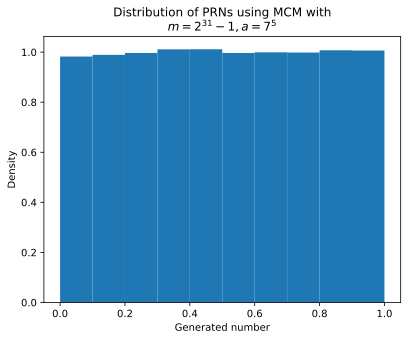

In [4]:
plt.hist(prng(x_0=10, num = 100_000), density=True)
plt.title("Distribution of PRNs using MCM with\n"+r"$m=2^{31}-1,a=7^5$")
plt.xlabel("Generated number")
plt.ylabel("Density")
plt.show()

Poor parameters, on the other hand, can lead to biased (nonuniform) PRNs; we can show this with the example parameter set $X_0 = 10, a=23^2,m=10002$:

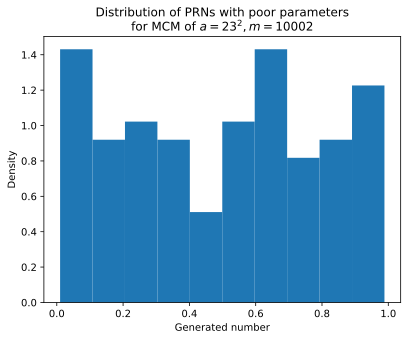

In [5]:
plt.hist(prng(x_0=10, a = 23**2, m = 10002, num=100), density=True)
plt.title("Distribution of PRNs with poor parameters\n"+r"for MCM of $a=23^2,m=10002$")
plt.xlabel("Generated number")
plt.ylabel("Density")
plt.show()

With some investigative work below, we can discover this parameter set to have a period of 833, meaning the sequence eventually gets stuck in a "loop" of 833 numbers. This is undesirable to say the least.

In [6]:
np.where(prng(x_0=10, a = 23**2, m = 10002, num=10_000, norm=False)[5000:] == 7852.0)[0][0]+1

833

## Testing uniformity

### Notable statistical tests

The evaluation of PRNGs is a well-studied field in statistics and computer science. Perhaps the two most popular statistical tests for randomness (i.e., conformity to a standard uniform distribution) are the chi-squared ($\chi^2$) goodness-of-fit test and the Kolmogorov-Smirnov (KS) test. Below I provide some intuition for the simpler of the two — the $\chi^2$ test — which can be used to measure how well a dataset conforms to an expected distribution of values.

Say we have $n$ observations from a PRNG method where each number lies in $[0,1]$, and we want to determine if the draws mirror a standard uniform (i.e., appear random). Imagine we then count the number of datapoints that lie in the four equal-width bins $[0,.25),[.25,.50)$ and so on such that we partition our data into four groups. Then, if the $n$ observations are truly independent and identically drawn from a standard uniform distribution, the number of observations we would (asymptotically) expect in each bin $i$ would be $n_i=.25\times n$.

The counts are often displayed in a table like so:

$$
\begin{array}{c|cccc|c}
 & [0,0.25) & [0.25,0.50) & [0.50,0.75) & [0.75,1] & \text{Total} \\
\hline
\text{Observed} & n_1 & n_2 & n_3 & n_4 & n \\
\text{Expected} & 0.25n & 0.25n & 0.25n & 0.25n & n \\
\end{array}
$$

If we assume that the PRNG is truly random and we normalize our counts such that $p_i=n_i/n$, our null hypothesis is $H_0:p_1=p_2=\dots=.25$, with the alternative hypothesis that the true proportions differ. To compute a $p$-value for the test, we can calculate the "deviance" from the expected number of values within each bin relative to the actual observed values. Thus, the $\chi^2$ test statistic is defined as

$$
\chi^2=\sum_{i=1}^k{\frac{(O_i-E_i)^2}{E_i}}
$$

where $k$ is the number of bins, and $O_i$ and $E_i$ are the observed and expected counts in bin $i$ respectively. This test statistic follows a chi-squared distribution with $k-1$ degrees of freedom, which means we can compute a $p$-value via $\mathbb{P}\left(\chi^2_{k-1} > \sum_{i=1}^k\left\{\frac{(O_i-E_i)^2}{E_i}\right\}\right)$<sup><a href='#fn3'>3</a></sup>. As a refresher, the interpretation of this value would be the probability of seeing a total deviance across our bins as extreme or more extreme than what was observed, if the values actually came from a uniform distribution over $[0,1]$.

### Other methods

The <a href="https://en.wikipedia.org/wiki/Diehard_tests" target="_blank">diehard tests</a> are a suite of statistical tests curated by computer scientist George Marsaglia to evaluate the performance of a PRNG. Below I briefly explore two techniques of interest for examining PRNG quality.

#### Birthday spacings

An off-shoot of the <a href="https://en.wikipedia.org/wiki/Birthday_problem" target="_blank">birthday problem</a>, the birthday spacing phenomenon says that if we choose $n$ random points uniformly on a sufficiently large $[1,m]$ interval, the spacings between the sorted points are asymptotically exponentially distributed. We can demonstrate this by simulation with $n=10^3,m=10^4$:

In [7]:
def birthday_spacings(n, m, method=np.random.rand):
    birthdays = np.sort(method(n)*m)
    spacings = birthdays[1:] - birthdays[:-1]
    return np.array(list(map(int,spacings)))

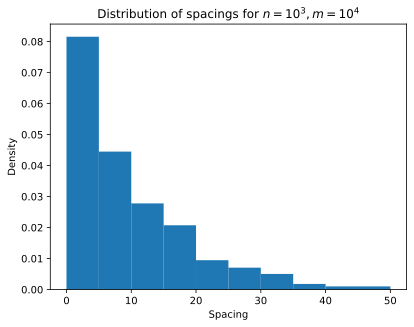

In [8]:
plt.hist(birthday_spacings(1000, 10_000), range=(0,50), density=True)
plt.title(r"Distribution of spacings for $n=10^3,m=10^4$")
plt.xlabel("Spacing")
plt.ylabel("Density")
plt.show()

We can use this result to examine the quality of any PRNG in question by seeing how well the spacings of numbers approximate an exponential distribution. Of course, to do this, we need the rate of the exponential distribution.

In the spirit of the birthday problem, imagine a scenario where we select a large number of people $n$ and a large range for possible birthdays $[1,m]$ such that $n< m$. The event that at least two people share a birthday is the complement of the event of all pairs having different birthdays. If we let $p(n,m)$ denote the former event and $\bar{p}(n,m)$ represent its complement, then we have

$$
\begin{align*}
\bar{p}(n,m) &=1\times\left(1-\frac{1}{m}\right)\times\left(1-\frac{2}{m}\right)\times\cdots\times\left(1-\frac{n-1}{m}\right)
\end{align*}
$$

and if we use the Taylor series expansion of $e^x$ (where $|x|\ll 1$) to yield a first-order approximation of $e^x\approx 1+x$, we have

$$
\begin{align*}
\bar{p}(n,m)&=1\times e^{-1/m}\times e^{-2/m}\times\cdots\times e^{-(n-1)/m} \\
&= \exp\left(\frac{-(1+2+\cdots+(n-1))}{m}\right) \\
&= \exp\left(-\frac{n(n-1)/2}{m}\right) = \exp\left(-\frac{n(n-1)}{2m}\right)
\end{align*}
$$

So finally, we have

$$
p(n,m)=1-\bar{p}(n,m)\approx1-e^{-\frac{n(n-1)}{2m}}
$$

The expected number of pairs that share a birthday is thus $n\cdot p(n,m)$, and the rate at which pairs share a birthday over $m$ days is just $\frac{n\cdot p(n,m)}{m}$. Our approximate expression for the rate of the exponential distribution is therefore:

$$
\lambda=n\times\left(1-\exp\left\{-\frac{n(n-1)}{2m}\right\}\right)\large/\normalsize m
$$

We can push the approximation further: if $n<m$ and $n,m$ are sufficiently large such that $n^2> m$ (a factor of $10$ will suffice), we have $e^{-\frac{n(n-1)}{2m}}\approx 0$, so the revised rate is

$$
\lambda\approx n\times\left(1-0\right)/m=n/m
$$

Plotting the exponential probability density function with $\lambda=n/m$ on top of the distribution of spacings between PRNs of good PRNGs, we can see it fits the distribution pretty well with $n=10^5,m=10^8$:

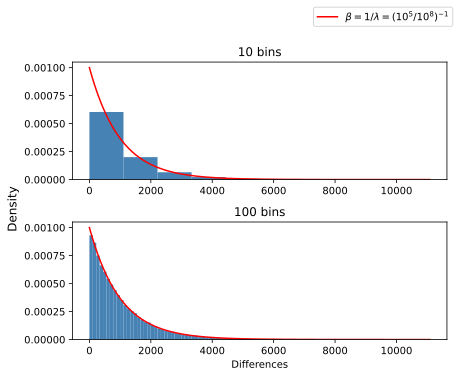

In [9]:
# <!-- collapse=True -->

fig, (ax1, ax2) = plt.subplots(2, 1)
s_vals = birthday_spacings(10**5, 10**8)
xs = np.linspace(0,np.max(s_vals),num=1000)
ax1.hist(s_vals, density=True, bins=10, color="steelblue")
ax1.plot(xs, scipy.stats.expon.pdf(xs, scale=10**8/10**5), label=r"$\beta=1/\lambda=(10^5/10^8)^{-1}$", color='red')

ax2.hist(s_vals, density=True, bins=100, color="steelblue")
ax2.plot(xs, scipy.stats.expon.pdf(xs, scale=10**8/10**5), color='red')

ax1.set_title("10 bins")
ax2.set_title("100 bins")
plt.xlabel("Differences")
fig.supylabel("Density")
fig.legend(bbox_to_anchor=(1,1.1))
fig.tight_layout()

# <end collapse>

Contrasting this with our poor parameter choices for the LCG, we exhibit a bad fit to the approximate exponential distribution:

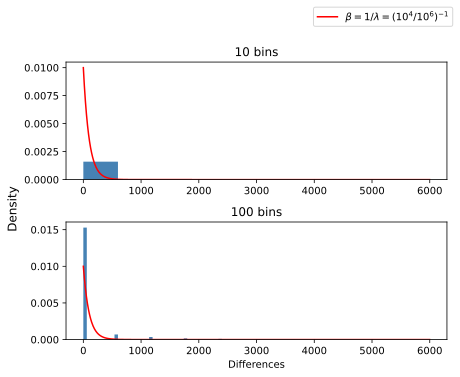

In [10]:
# <!-- collapse=True -->

fig, (ax1, ax2) = plt.subplots(2, 1)
s_vals = birthday_spacings(10**4, 10**6, method = lambda n: prng(x_0=10, a = 23**2, m = 10002, num=n))
xs = np.linspace(0,np.max(s_vals),num=1000)
ax1.hist(s_vals, density=True, bins=10, color="steelblue")
ax1.plot(xs, scipy.stats.expon.pdf(xs, scale=10**6/10**4), label=r"$\beta=1/\lambda=(10^4/10^6)^{-1}$", color='red')

ax2.hist(s_vals, density=True, bins=100, color="steelblue")
ax2.plot(xs, scipy.stats.expon.pdf(xs, scale=10**6/10**4), color='red')

ax1.set_title("10 bins")
ax2.set_title("100 bins")
plt.xlabel("Differences")
fig.supylabel("Density")
# ax1.set_xlim((0, 12000))
# ax2.set_xlim((0, 12000))
fig.legend(bbox_to_anchor=(1,1.1))
fig.tight_layout()

# <end collapse>

#### Runs tests

The Wald-Wolfowitz test (runs test) is a way of assessing the randomness of a sequence of two-valued (dichotomous) data by counting the number of "runs" in the sequence. For example, the string of coin flips `HHHHTTTHHTTTTHHHHTTT` has six total runs: three consecutive substrings for heads and tails each. Under the null hypothesis that each coin flip is independently and identically distributed with probability $1/2$, the number of runs in a sequence of $N$ elements approximates a normal distribution $N(\mu,\sigma^2)$ where

$$
\begin{align*}
\mu&=\frac{2n_+n_-}{n_++n_-}+1 \\
\sigma^2&=\frac{2n_+n_-(2n_+n_--n_+-n_-)}{(n_++n_-)^2(n_++n_--1)}=\frac{(\mu-1)(\mu-2)}{n-1}
\end{align*}
$$

and $n_+,n_-$ are the number of positive and negative values (synonymously, success and failure counts) in the sequence.

In the context of PRNGs, if our data were generated uniformly, then we know half the data should lie above the median and half should lie below the median. In a sequence of generated PRNs over $[0,1]$, we can therefore let $n_+,n_-$ correspond to the number of values above and below the median $.5$, respectively. We can demonstrate the approximation to the above normal with NumPy's PRNG:

In [11]:
def get_runs(seq):
    """ Return the number of positive, negative, and total runs
    within a sequence. """
    ns = {-1:0, 1:0}
    diffs = np.sign(seq - np.median(seq))
    diffs = diffs[np.where(diffs != 0)] # omit ties
    ns[diffs[0]] = 1
    
    for i in range(1, len(diffs)):
        if diffs[i] != diffs[i-1]: ns[diffs[i]] += 1
    
    return (ns[1], ns[-1], (ns[1]+ns[-1]))

def get_run_stats(seq=[], ns=None):
    """ Return the mean and variance of a sequence of runs, or the
    calculated mean and variance with numbers of runs. """
    assert len(seq)>0 or ns is not None
    if len(seq)>0:
        median = np.median(seq)
        nplus = np.sum(seq > median)
        nneg = np.sum(seq < median)
    else:
        nplus, nneg = ns
    n = nplus + nneg # omit seq = median
    
    mu = (2*nplus*nneg)/n + 1
    var = ((mu - 1)*(mu - 2))/(n - 1)
    
    return (mu, var)

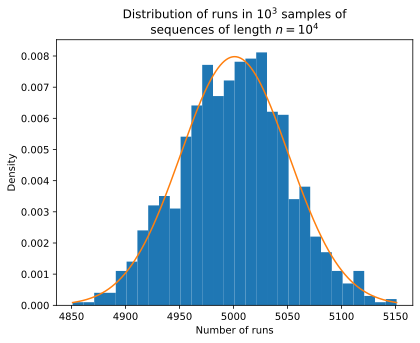

In [12]:
samples = 10_000
empirical_n = [get_runs(np.random.rand(samples))[2] for _ in range(1000)]

mu, var = get_run_stats(ns=(samples/2, samples/2))
x_vals = np.linspace(mu-3*np.sqrt(var),mu+3*np.sqrt(var),num=1000)
h = plt.hist(empirical_n, density=True, bins=30, range=(mu-3*np.sqrt(var),mu+3*np.sqrt(var)))
plt.plot(x_vals, scipy.stats.norm.pdf(x_vals, loc=mu, scale=np.sqrt(var)))
plt.xlabel("Number of runs")
plt.ylabel("Density")
plt.title(r"Distribution of runs in $10^3$ samples of"+"\n"+r"sequences of length $n=10^4$")
plt.show()

And to test the null hypothesis that the data are random against the alternative that the data are not random, we begin by noting that under $H_0$, $n_+=n_-=n/2$. We can then create a test statistic for any sequence with $R$ sample runs by the normalized deviance $\frac{R-\mu}{\sigma}$ and calculate a $p$-value by performing a two-sided $Z$-test:

$$
p=2\times\mathbb{P}\left(Z>\left|\frac{R-\mu}{\sigma}\right|\right)
$$

With a good PRNG, we exhibit uniformly-distributed $p$-values since the null hypothesis is true<sup><a href='#fn'>4</a></sup>:

In [13]:
arr = [0]*1000
for i in range(1000):
    a = np.random.rand(100_000)
    mu, var = get_run_stats(ns=(len(a)/2,len(a)/2))
    zstat = (get_runs(a)[2] - mu)/np.sqrt(var)
    arr[i] = 2*(1-scipy.stats.norm.cdf(np.abs(zstat)))

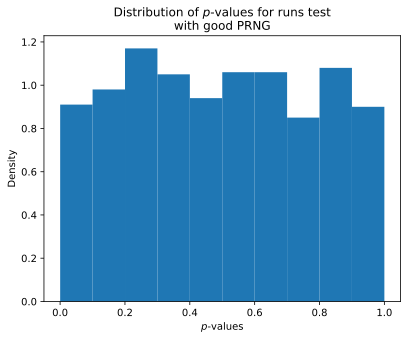

In [14]:
plt.hist(arr, density=True)
plt.xlabel(r"$p$-values")
plt.ylabel("Density")
plt.title(r"Distribution of $p$-values for runs test"+"\nwith good PRNG")
plt.show()

And with our poor-performing LCG, we observe $p$-values concentrated toward $0$, implying strong evidence that the data are not random.

In [15]:
arr2 = [0]*1000
for i in range(1_000):
    a = prng(x_0=int(np.random.rand()*10 + 1), a = 23**2, m = 10002, num=100_000)
    mu, var = get_run_stats(ns=(len(a)/2,len(a)/2))
    zstat = (get_runs(a)[2] - mu)/np.sqrt(var)
    arr2[i] = 2*(1-scipy.stats.norm.cdf(np.abs(zstat)))

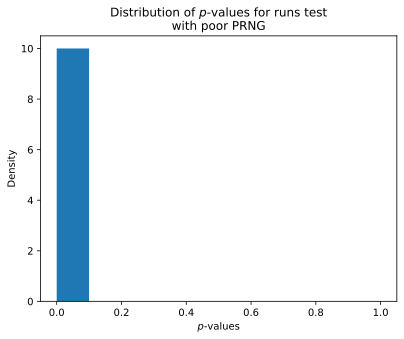

In [16]:
plt.hist(arr2, density=True, range=(0,1))
plt.xlabel(r"$p$-values")
plt.ylabel("Density")
plt.title(r"Distribution of $p$-values for runs test"+"\nwith poor PRNG")
plt.show()

The difference is more stark when comparing cumulative proportion plots:

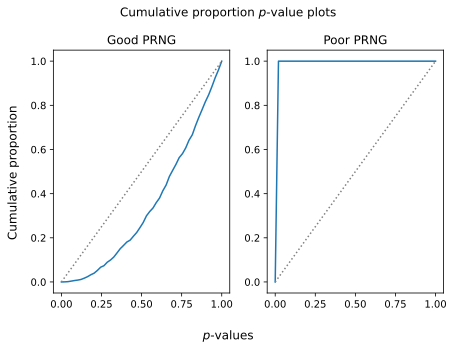

In [17]:
# <!-- collapse=True -->

arrp, arr2p = np.array(arr), np.array(arr2)
cumval = np.linspace(0,1,50)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(cumval,[np.sum(arrp[arrp <= cumv])/np.sum(arrp) for cumv in cumval])
ax1.plot(cumval, cumval, color='grey', linestyle='dotted')

ax2.plot(cumval,[np.sum(arr2p[arr2p < cumv])/np.sum(arr2p) for cumv in cumval])
ax2.plot(cumval, cumval, color='grey', linestyle='dotted')

fig.suptitle(r"Cumulative proportion $p$-value plots")
ax1.set_title("Good PRNG")
ax2.set_title("Poor PRNG")
fig.supxlabel(r"$p$-values")
fig.supylabel("Cumulative proportion")
fig.tight_layout()

# <end collapse>

## Evaluating ChatGPT's random numbers

### Method

To evaluate ChatGPT's random numbers, I collected a total of 1,836 numbers in the range $[0,1]$ to a precision of six decimal places. This was done by prompting ChatGPT in a new conversation with the phrase "Give me 1,000 random numbers in the range [0,1] to 6 decimal places, separated by a comma"<sup><a href='#fn5'>5</a></sup> and I used the keyword "continue" a total of 11 times to resume text generation when ChatGPT stopped outputting text. You can download the CSV of the generated numbers [here](https://blademaw.github.io/features/files/chatgpt_nums.csv).

### Results

To begin, we can plot the density of the generated numbers to observe a roughly uniform distribution of the data:

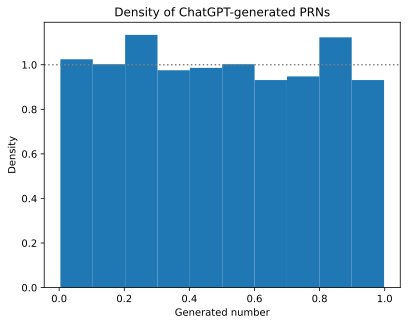

In [18]:
nums_df = pd.read_csv("../mydata/chatgpt_nums.csv", header=None)
nums = np.array(nums_df[0])

plt.hist(nums, density=True)
plt.title("Density of ChatGPT-generated PRNs")
plt.xlabel("Generated number")
plt.ylabel("Density")
plt.axhline(1, color='grey', linestyle='dotted')
plt.show()

So far so good — to the human eye, these numbers _look_ random. If we sort the data and take the differences between adjacent pairs, we can examine how well the spacings approximate the asymptotic exponential distribution with $\lambda=n/m=1836/10^6$:

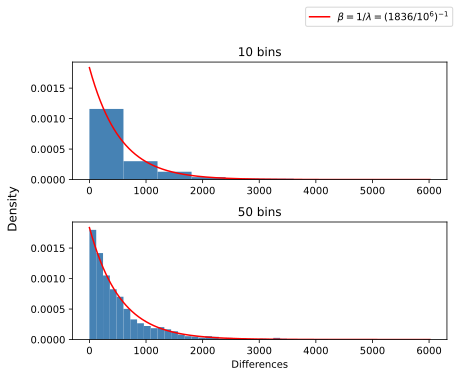

In [19]:
# <!-- collapse=True -->

xvp = np.sort(nums*1e6) # adjust by 1e6, sort & take differences
xvp = xvp[1:] - xvp[:-1]
c_n, c_m = len(nums), 10**6

fig, (ax1, ax2) = plt.subplots(2, 1)
xs = np.linspace(0,np.max(xvp),num=1000)
ax1.hist(xvp, density=True, bins=10, color="steelblue")
ax1.plot(xs, scipy.stats.expon.pdf(xs, scale=1/(c_n/c_m)), label=r"$\beta=1/\lambda=(1836/10^6)^{-1}$", color='red')

ax2.hist(xvp, density=True, bins=50, color="steelblue")
ax2.plot(xs, scipy.stats.expon.pdf(xs, scale=1/(c_n/c_m)), color='red')

ax1.set_title("10 bins")
ax2.set_title("50 bins")
plt.xlabel("Differences")
fig.supylabel("Density")
fig.legend(bbox_to_anchor=(1,1.1))
fig.tight_layout()

# <end collapse>

which looks pretty good, suggesting the data are truly random — remember, the birthday spacings phenomenon only really kicks in if $n,m$ are large, so a result like this for $n=1836$ is promising.

If we take our unsorted random numbers, we observe 937 total runs, close to the expected value from the approximate normal distribution:

In [20]:
# observed runs
print(get_runs(nums)[2])
# expected runs (mu, var)
mu, var = get_run_stats(ns=(len(nums)/2,len(nums)/2))
print(f"{mu} ±{np.round(np.sqrt(var),2)}")

937
919.0 ±21.42


With the distribution and observed data, we can perform a $Z$-test by calculating our test statistic

In [21]:
zstat = (get_runs(nums)[2] - mu)/np.sqrt(var);zstat

0.8403970726509675

and calculating our two-sided $p$-value:

In [22]:
# p-value
2*(1-scipy.stats.norm.cdf(np.abs(zstat)))

0.40068578993105564

With $p\approx.4$, the chance of observing a number of runs as or more extreme than what we observed is $\approx40\%$, so at the $\alpha=5\%$ significance level, we fail to reject the null hypothesis that the data are truly random.

To round things off, we can perform our two goodness-of-fit tests — a KS test with our continuous dataset, and a $\chi^2$ test after discretizing into binned counts. The KS test with

$$
H_0: X\sim U(0,1) \\
\text{vs} \\
H_A: X\not\sim U(0,1)
$$

results in $p\approx.64$:

In [23]:
scipy.stats.kstest(nums, scipy.stats.uniform.cdf)

KstestResult(statistic=0.01718082788671027, pvalue=0.6439810466273829)

Implying we continue to lack sufficient evidence the data do not follow a standard uniform distribution.

To perform a $\chi^2$ goodness-of-fit test, we can perform equal-width discretization over $[0,1]$ and sum the squared deviations from the expected values over the expected values to obtain a test statistic:

In [24]:
counts = [np.sum(np.multiply(nums >= a, nums < b)) for a,b in [(.0,.25),(.25,.50),(.50,.75),(.75,1.)]]
e_counts = .25*np.sum(counts) # expected counts
ts = np.sum((counts - e_counts)**2/e_counts);ts # TS for Chi-squared goodness-of-fit test

0.6840958605664488

Since this follows a $\chi^2$ distribution with three degrees of freedom, the resulting $p$-value under the null that equal proportions of counts lie in the four bins (and thus the data are random) is:

In [25]:
1 - scipy.stats.chi2.cdf(ts, df=3) # p-value

0.8769382342067042

and with $p\approx.88$, we again fail to reject the null at any reasonable significance level.

### Discussion

ChatGPT's numbers passed all three inspections for uniformity. This is unintuitive for two main reasons: the first reason is that a model trained on human data should approximate human-like responses; humans are bad randomizers, so it follows ChatGPT should be too.

Secondly, a predictive language model is dependent on previous output, meaning its numbers should not be uniformly independently and identically distributed unless part of its training data included random numbers (more on this later). In some cases, ChatGPT even demonstrates its limitations by entering a steady state, outputting a singular number repeatedly (see images below).

<figure class="styled"><img class="styled" src="/images/convergence1.png" width="536" height="256" alt="One instance of ChatGPT's convergence for random numbers"><figcaption>First example of convergence.</figcaption></figure>

<figure class="styled"><img class="styled" src="/images/convergence2.png" width="536" height="348" alt="Another instance of ChatGPT's convergence for random numbers"><figcaption>Second example of convergence.</figcaption></figure>

When confronted about these points, ChatGPT has a tendency to claim that it generates pseudorandom numbers with a _proprietary algorithm_ — that is, it implements some PRNG behind the scenes. It also claims that when supplied with a seed, it will deterministically generate numbers (refer to the transcript in the appendix for the full answer). However, when prompted in two different conversations with the same seed, ChatGPT produces clearly distinct numbers:

<figure class="styled"><img class="styled" src="/images/seed1.png" width="600" height="150" alt="ChatGPT producing .77 for requested seed"><figcaption>ChatGPT produces .77 with seed 51245.</figcaption></figure>

<figure class="styled"><img class="styled" src="/images/seed2.png" width="600" height="150" alt="ChatGPT producing .36 for requested seed"><figcaption>ChatGPT produces .36 with seed 51245.</figcaption></figure>

If ChatGPT actually used a PRNG, it *would* explain the uniformity of our data. Obviously, the screenshots show this is not the case, and it's extremely unlikely the OpenAI team specifically implemented a PRNG for ChatGPT (a language model built for qualitative tasks). So with all this in mind, why do ChatGPT's dependent, text-based random numbers perform well on the uniformity tests?

The short answer is — I don't know, but if we operate under the likely assumption that ChatGPT isn't using a PRNG, then the only culprit is the training data. In other words, the uniformity exhibited in the dataset is simply a byproduct of the patterns in its training corpus — if ChatGPT's training data included sequences of PRNs, it's likely the output for random number generation is a result of matching previous random numbers to its model, and continuously building a collection of numbers.

More intuitively put, if the training data contained PRNs from good quality PRNGs, then any sequence in the training data regardless of seed (i.e., across all documents) that provides the closest match to ChatGPT's previous number(s) can provide a new number that appears independent of the previous number(s) (by the properties of a good PRNG). While this is a total guess, it would explain the apparent uniformity exhibited.

### Conclusion

In summary, when prompted for random numbers over the range $[0,1]$ to six decimal place precision, ChatGPT was able to generate a dataset of $n=1836$ numbers that passed the three statistical tests for uniformity examined in this post. However, ChatGPT's output to a prompt for random number generation can converge to non-random sequences, as is clearly demonstrated in above images.

Despite its (likely false) claims of using a PRNG for output, ChatGPT's responses are ultimately a result of a probabilistic language model conditional on context, so it is entirely possible that similar (or even identical) requests to the one I made to produce the dataset in this post may result in a distinctly non-random distribution of numbers.

While this makes it difficult to make universal statements about ChatGPT's PRNG quality, given that we have found no statistical evidence to suggest the numbers generated from ChatGPT in this instance were not truly random, we are able to conservatively conclude that under the right circumstances, ChatGPT's random number generation appears to mimic a good quality PRNG.

Footnotes [^fn1][^fn2][^fn3][^fn4][^fn5]:

[^fn1]: <a id='fn1' style='color: inherit; text-decoration:none;'>In</a> simulation or modeling, for example, an accompanying seed can be useful for demonstrating edge-case model behavior; furthermore, specifying the seed in the context of machine learning or statistical procedures is common to reproduce random sampling.

[^fn2]: <a id='fn2' style='color: inherit; text-decoration:none;'>See</a> https://dspace.library.uvic.ca:8443/bitstream/handle/1828/3142/Random_Number_Generators.pdf for further reading.

[^fn3]: <a id='fn3' style='color: inherit; text-decoration:none;'>Recall</a> that $\chi^2$ is a squared distribution, so we even though this test is two-sided, we do not double the resulting probability like we would with a $Z$-test.

[^fn4]: <a id='fn4' style='color: inherit; text-decoration:none;'>Refer</a> to P-Values are Random Variables by Murdoch, D, Tsai, Y, and Adcock, J (2008) for other examples and a didactic approach.

[^fn5]: <a id='fn5' style='color: inherit; text-decoration:none;'>Even</a> though I continued collection to 1,836 numbers, the numbers did not begin repeating after 1,000 values.


# Appendix

The full transcription for ChatGPT's explanation of its output for random number requests is below:

Q: *What happens when I ask ChatGPT to generate a random number?*

A:
> When you ask ChatGPT to generate a random number, it will use a specific algorithm to produce a sequence of numbers that appear to be random. This algorithm is called a "pseudo-random number generator", which is based on a deterministic mathematical process that produces a sequence of numbers that appear to be random.<br/><br/>
The algorithm used by ChatGPT for generating random numbers involves selecting a starting point or "seed" value, and then performing a series of mathematical operations on that value to produce a new value. The resulting value is then used as the seed for the next calculation, and so on.<br/><br/>
The sequence of numbers produced by this process is deterministic, meaning that if the same starting seed value is used, the sequence of numbers will be exactly the same each time. However, the sequence of numbers appears to be random because the calculation process is complex and difficult to predict.<br/><br/>
When you ask ChatGPT to generate a random number, it will use this algorithm to produce a number that appears to be random. The number may be a whole number, a decimal number, or a combination of both, depending on how the algorithm is configured.<br/><br/>
It's important to note that while the numbers generated by ChatGPT may appear to be random, they are not truly random in the sense of being unpredictable. If you know the starting seed value and the algorithm used, you can predict the sequence of numbers that will be produced. However, for most practical purposes, the numbers generated by ChatGPT are usually sufficiently random.

Q: *So if I give ChatGPT a seed and ask it to generate a random number, it will generate the same number with the same seed every time, even if I start a new conversation?*

A:
> Yes, that's correct. If you give ChatGPT a specific seed and ask it to generate a random number, it will produce the same number every time you give it that same seed, regardless of whether you start a new conversation or continue an existing one.<br/><br/>
This is because the pseudo-random number generator algorithm used by ChatGPT is deterministic, meaning that it will always produce the same sequence of numbers when given the same seed. This property is useful in many applications where you need a repeatable sequence of random numbers.<br/><br/>
However, if you give ChatGPT a different seed, it will produce a different sequence of numbers. So, if you want to generate a different random number each time, you can use a different seed value each time you ask ChatGPT to generate a random number.<br/><br/>
It's important to note that while the numbers generated by ChatGPT may appear to be random, they are not truly random in the sense of being unpredictable. If you know the seed value and the algorithm used, you can predict the sequence of numbers that will be produced.